In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_e_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(701688, 919)
(701688, 8)
validation
(129856, 919)
(129856, 8)
test
(60456, 919)
(60456, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1632136 (6.23 MB)


Trainable params: 1632136 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/71 [..............................] - ETA: 1:34 - loss: 2.0367 - STD: 0.0575 - MAE: 0.2159

 4/71 [>.............................] - ETA: 1s - loss: 1.6486 - STD: 0.1198 - MAE: 0.1816  

 7/71 [=>............................] - ETA: 1s - loss: 1.5677 - STD: 0.1670 - MAE: 0.1626

10/71 [===>..........................] - ETA: 1s - loss: 1.5258 - STD: 0.1801 - MAE: 0.1569

14/71 [====>.........................] - ETA: 0s - loss: 1.4932 - STD: 0.1761 - MAE: 0.1576

17/71 [======>.......................] - ETA: 0s - loss: 1.4813 - STD: 0.1732 - MAE: 0.1584

20/71 [=======>......................] - ETA: 0s - loss: 1.4714 - STD: 0.1741 - MAE: 0.1579

23/71 [========>.....................] - ETA: 0s - loss: 1.4643 - STD: 0.1768 - MAE: 0.1568

26/71 [=========>....................] - ETA: 0s - loss: 1.4585 - STD: 0.1789 - MAE: 0.1559

29/71 [===========>..................] - ETA: 0s - loss: 1.4525 - STD: 0.1793 - MAE: 0.1556

32/71 [============>.................] - ETA: 0s - loss: 1.4481 - STD: 0.1786 - MAE: 0.1558

33/71 [============>.................] - ETA: 1s - loss: 1.4477 - STD: 0.1782 - MAE: 0.1559

37/71 [==============>...............] - ETA: 1s - loss: 1.4418 - STD: 0.1776 - MAE: 0.1560

40/71 [===============>..............] - ETA: 1s - loss: 1.4382 - STD: 0.1780 - MAE: 0.1558

43/71 [=================>............] - ETA: 0s - loss: 1.4350 - STD: 0.1786 - MAE: 0.1555

46/71 [==================>...........] - ETA: 0s - loss: 1.4324 - STD: 0.1789 - MAE: 0.1553

49/71 [===================>..........] - ETA: 0s - loss: 1.4300 - STD: 0.1788 - MAE: 0.1553

52/71 [====================>.........] - ETA: 0s - loss: 1.4271 - STD: 0.1786 - MAE: 0.1553

55/71 [======================>.......] - ETA: 0s - loss: 1.4253 - STD: 0.1786 - MAE: 0.1552

58/71 [=======================>......] - ETA: 0s - loss: 1.4241 - STD: 0.1787 - MAE: 0.1552

61/71 [========================>.....] - ETA: 0s - loss: 1.4219 - STD: 0.1787 - MAE: 0.1551

65/71 [==========================>...] - ETA: 0s - loss: 1.4198 - STD: 0.1787 - MAE: 0.1551

68/71 [===========================>..] - ETA: 0s - loss: 1.4181 - STD: 0.1787 - MAE: 0.1550

71/71 [==============================] - ETA: 0s - loss: 1.4164 - STD: 0.1787 - MAE: 0.1549

71/71 [==============================] - 4s 38ms/step - loss: 1.4164 - STD: 0.1787 - MAE: 0.1549 - val_loss: 1.3005 - val_STD: 0.1789 - val_MAE: 0.1486


Epoch 2/10000


 1/71 [..............................] - ETA: 3s - loss: 1.3743 - STD: 0.1779 - MAE: 0.1538

 4/71 [>.............................] - ETA: 1s - loss: 1.3645 - STD: 0.1780 - MAE: 0.1533

 7/71 [=>............................] - ETA: 1s - loss: 1.3629 - STD: 0.1789 - MAE: 0.1529

10/71 [===>..........................] - ETA: 1s - loss: 1.3593 - STD: 0.1788 - MAE: 0.1529

13/71 [====>.........................] - ETA: 1s - loss: 1.3541 - STD: 0.1793 - MAE: 0.1525

16/71 [=====>........................] - ETA: 1s - loss: 1.3458 - STD: 0.1800 - MAE: 0.1519

20/71 [=======>......................] - ETA: 0s - loss: 1.3397 - STD: 0.1821 - MAE: 0.1508

23/71 [========>.....................] - ETA: 0s - loss: 1.3340 - STD: 0.1830 - MAE: 0.1503

26/71 [=========>....................] - ETA: 0s - loss: 1.3284 - STD: 0.1837 - MAE: 0.1499

29/71 [===========>..................] - ETA: 0s - loss: 1.3241 - STD: 0.1837 - MAE: 0.1498

32/71 [============>.................] - ETA: 0s - loss: 1.3197 - STD: 0.1841 - MAE: 0.1496

35/71 [=============>................] - ETA: 0s - loss: 1.3152 - STD: 0.1848 - MAE: 0.1492

38/71 [===============>..............] - ETA: 0s - loss: 1.3111 - STD: 0.1852 - MAE: 0.1490

41/71 [================>.............] - ETA: 0s - loss: 1.3059 - STD: 0.1855 - MAE: 0.1487

44/71 [=================>............] - ETA: 0s - loss: 1.3026 - STD: 0.1858 - MAE: 0.1485

47/71 [==================>...........] - ETA: 0s - loss: 1.2981 - STD: 0.1861 - MAE: 0.1483

50/71 [====================>.........] - ETA: 0s - loss: 1.2947 - STD: 0.1864 - MAE: 0.1481

53/71 [=====================>........] - ETA: 0s - loss: 1.2905 - STD: 0.1867 - MAE: 0.1479

56/71 [======================>.......] - ETA: 0s - loss: 1.2869 - STD: 0.1870 - MAE: 0.1477

59/71 [=======================>......] - ETA: 0s - loss: 1.2834 - STD: 0.1873 - MAE: 0.1475

62/71 [=========================>....] - ETA: 0s - loss: 1.2801 - STD: 0.1874 - MAE: 0.1474

65/71 [==========================>...] - ETA: 0s - loss: 1.2763 - STD: 0.1876 - MAE: 0.1472

68/71 [===========================>..] - ETA: 0s - loss: 1.2733 - STD: 0.1879 - MAE: 0.1470

71/71 [==============================] - ETA: 0s - loss: 1.2699 - STD: 0.1881 - MAE: 0.1468

71/71 [==============================] - 2s 22ms/step - loss: 1.2699 - STD: 0.1881 - MAE: 0.1468 - val_loss: 1.1372 - val_STD: 0.1891 - val_MAE: 0.1399


Epoch 3/10000


 1/71 [..............................] - ETA: 3s - loss: 1.1841 - STD: 0.1884 - MAE: 0.1441

 4/71 [>.............................] - ETA: 1s - loss: 1.1946 - STD: 0.1904 - MAE: 0.1438

 7/71 [=>............................] - ETA: 1s - loss: 1.1924 - STD: 0.1936 - MAE: 0.1426

10/71 [===>..........................] - ETA: 1s - loss: 1.1916 - STD: 0.1929 - MAE: 0.1429

13/71 [====>.........................] - ETA: 1s - loss: 1.1902 - STD: 0.1922 - MAE: 0.1432

16/71 [=====>........................] - ETA: 1s - loss: 1.1867 - STD: 0.1930 - MAE: 0.1427

19/71 [=======>......................] - ETA: 0s - loss: 1.1835 - STD: 0.1932 - MAE: 0.1425

22/71 [========>.....................] - ETA: 0s - loss: 1.1798 - STD: 0.1928 - MAE: 0.1425

25/71 [=========>....................] - ETA: 0s - loss: 1.1747 - STD: 0.1934 - MAE: 0.1420

28/71 [==========>...................] - ETA: 0s - loss: 1.1712 - STD: 0.1938 - MAE: 0.1417

31/71 [============>.................] - ETA: 0s - loss: 1.1672 - STD: 0.1938 - MAE: 0.1415

34/71 [=============>................] - ETA: 0s - loss: 1.1631 - STD: 0.1943 - MAE: 0.1411

37/71 [==============>...............] - ETA: 0s - loss: 1.1587 - STD: 0.1945 - MAE: 0.1409

40/71 [===============>..............] - ETA: 0s - loss: 1.1544 - STD: 0.1949 - MAE: 0.1405

43/71 [=================>............] - ETA: 0s - loss: 1.1509 - STD: 0.1954 - MAE: 0.1402

46/71 [==================>...........] - ETA: 0s - loss: 1.1470 - STD: 0.1958 - MAE: 0.1398

49/71 [===================>..........] - ETA: 0s - loss: 1.1441 - STD: 0.1961 - MAE: 0.1396

52/71 [====================>.........] - ETA: 0s - loss: 1.1408 - STD: 0.1966 - MAE: 0.1393

55/71 [======================>.......] - ETA: 0s - loss: 1.1371 - STD: 0.1967 - MAE: 0.1391

58/71 [=======================>......] - ETA: 0s - loss: 1.1335 - STD: 0.1973 - MAE: 0.1387

61/71 [========================>.....] - ETA: 0s - loss: 1.1305 - STD: 0.1976 - MAE: 0.1384

64/71 [==========================>...] - ETA: 0s - loss: 1.1275 - STD: 0.1978 - MAE: 0.1382

67/71 [===========================>..] - ETA: 0s - loss: 1.1240 - STD: 0.1984 - MAE: 0.1378

70/71 [============================>.] - ETA: 0s - loss: 1.1205 - STD: 0.1987 - MAE: 0.1376

71/71 [==============================] - 2s 22ms/step - loss: 1.1202 - STD: 0.1989 - MAE: 0.1374 - val_loss: 1.0159 - val_STD: 0.2102 - val_MAE: 0.1251


Epoch 4/10000


 1/71 [..............................] - ETA: 3s - loss: 1.0493 - STD: 0.2099 - MAE: 0.1297

 4/71 [>.............................] - ETA: 1s - loss: 1.0344 - STD: 0.2074 - MAE: 0.1301

 7/71 [=>............................] - ETA: 1s - loss: 1.0281 - STD: 0.2063 - MAE: 0.1303

10/71 [===>..........................] - ETA: 1s - loss: 1.0254 - STD: 0.2081 - MAE: 0.1295

13/71 [====>.........................] - ETA: 1s - loss: 1.0235 - STD: 0.2091 - MAE: 0.1290

16/71 [=====>........................] - ETA: 1s - loss: 1.0220 - STD: 0.2089 - MAE: 0.1290

19/71 [=======>......................] - ETA: 0s - loss: 1.0170 - STD: 0.2089 - MAE: 0.1287

22/71 [========>.....................] - ETA: 0s - loss: 1.0136 - STD: 0.2092 - MAE: 0.1285

25/71 [=========>....................] - ETA: 0s - loss: 1.0094 - STD: 0.2100 - MAE: 0.1279

28/71 [==========>...................] - ETA: 0s - loss: 1.0053 - STD: 0.2106 - MAE: 0.1275

31/71 [============>.................] - ETA: 0s - loss: 1.0020 - STD: 0.2108 - MAE: 0.1273

34/71 [=============>................] - ETA: 0s - loss: 0.9979 - STD: 0.2111 - MAE: 0.1270

37/71 [==============>...............] - ETA: 0s - loss: 0.9945 - STD: 0.2116 - MAE: 0.1266

40/71 [===============>..............] - ETA: 0s - loss: 0.9907 - STD: 0.2121 - MAE: 0.1262

43/71 [=================>............] - ETA: 0s - loss: 0.9880 - STD: 0.2124 - MAE: 0.1259

46/71 [==================>...........] - ETA: 0s - loss: 0.9858 - STD: 0.2127 - MAE: 0.1257

49/71 [===================>..........] - ETA: 0s - loss: 0.9837 - STD: 0.2131 - MAE: 0.1255

52/71 [====================>.........] - ETA: 0s - loss: 0.9817 - STD: 0.2133 - MAE: 0.1253

55/71 [======================>.......] - ETA: 0s - loss: 0.9793 - STD: 0.2137 - MAE: 0.1250

58/71 [=======================>......] - ETA: 0s - loss: 0.9769 - STD: 0.2139 - MAE: 0.1248

61/71 [========================>.....] - ETA: 0s - loss: 0.9750 - STD: 0.2141 - MAE: 0.1246

65/71 [==========================>...] - ETA: 0s - loss: 0.9729 - STD: 0.2145 - MAE: 0.1244

68/71 [===========================>..] - ETA: 0s - loss: 0.9711 - STD: 0.2147 - MAE: 0.1242

71/71 [==============================] - ETA: 0s - loss: 0.9689 - STD: 0.2150 - MAE: 0.1240

71/71 [==============================] - 2s 22ms/step - loss: 0.9689 - STD: 0.2150 - MAE: 0.1240 - val_loss: 0.9839 - val_STD: 0.2180 - val_MAE: 0.1209


Epoch 5/10000


 1/71 [..............................] - ETA: 3s - loss: 0.9142 - STD: 0.2236 - MAE: 0.1171

 4/71 [>.............................] - ETA: 1s - loss: 0.9183 - STD: 0.2219 - MAE: 0.1184

 7/71 [=>............................] - ETA: 1s - loss: 0.9202 - STD: 0.2215 - MAE: 0.1188

10/71 [===>..........................] - ETA: 1s - loss: 0.9213 - STD: 0.2219 - MAE: 0.1187

13/71 [====>.........................] - ETA: 1s - loss: 0.9229 - STD: 0.2222 - MAE: 0.1186

16/71 [=====>........................] - ETA: 1s - loss: 0.9239 - STD: 0.2219 - MAE: 0.1189

19/71 [=======>......................] - ETA: 0s - loss: 0.9229 - STD: 0.2216 - MAE: 0.1190

22/71 [========>.....................] - ETA: 0s - loss: 0.9225 - STD: 0.2217 - MAE: 0.1189

25/71 [=========>....................] - ETA: 0s - loss: 0.9205 - STD: 0.2220 - MAE: 0.1187

28/71 [==========>...................] - ETA: 0s - loss: 0.9198 - STD: 0.2221 - MAE: 0.1186

31/71 [============>.................] - ETA: 0s - loss: 0.9189 - STD: 0.2221 - MAE: 0.1185

34/71 [=============>................] - ETA: 0s - loss: 0.9180 - STD: 0.2221 - MAE: 0.1185

37/71 [==============>...............] - ETA: 0s - loss: 0.9177 - STD: 0.2221 - MAE: 0.1185

40/71 [===============>..............] - ETA: 0s - loss: 0.9170 - STD: 0.2223 - MAE: 0.1184

44/71 [=================>............] - ETA: 0s - loss: 0.9165 - STD: 0.2224 - MAE: 0.1183

47/71 [==================>...........] - ETA: 0s - loss: 0.9155 - STD: 0.2226 - MAE: 0.1181

50/71 [====================>.........] - ETA: 0s - loss: 0.9145 - STD: 0.2227 - MAE: 0.1180

53/71 [=====================>........] - ETA: 0s - loss: 0.9139 - STD: 0.2228 - MAE: 0.1180

56/71 [======================>.......] - ETA: 0s - loss: 0.9129 - STD: 0.2229 - MAE: 0.1179

59/71 [=======================>......] - ETA: 0s - loss: 0.9120 - STD: 0.2229 - MAE: 0.1178

62/71 [=========================>....] - ETA: 0s - loss: 0.9117 - STD: 0.2229 - MAE: 0.1178

65/71 [==========================>...] - ETA: 0s - loss: 0.9110 - STD: 0.2230 - MAE: 0.1177

68/71 [===========================>..] - ETA: 0s - loss: 0.9104 - STD: 0.2232 - MAE: 0.1176

71/71 [==============================] - ETA: 0s - loss: 0.9098 - STD: 0.2233 - MAE: 0.1176

71/71 [==============================] - 2s 22ms/step - loss: 0.9098 - STD: 0.2233 - MAE: 0.1176 - val_loss: 1.0105 - val_STD: 0.2190 - val_MAE: 0.1222


Epoch 6/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8875 - STD: 0.2224 - MAE: 0.1168

 4/71 [>.............................] - ETA: 1s - loss: 0.8970 - STD: 0.2240 - MAE: 0.1166

 8/71 [==>...........................] - ETA: 1s - loss: 0.8972 - STD: 0.2246 - MAE: 0.1163

11/71 [===>..........................] - ETA: 1s - loss: 0.8939 - STD: 0.2251 - MAE: 0.1160

14/71 [====>.........................] - ETA: 0s - loss: 0.8914 - STD: 0.2254 - MAE: 0.1157

17/71 [======>.......................] - ETA: 0s - loss: 0.8902 - STD: 0.2258 - MAE: 0.1154

20/71 [=======>......................] - ETA: 0s - loss: 0.8903 - STD: 0.2259 - MAE: 0.1154

23/71 [========>.....................] - ETA: 0s - loss: 0.8905 - STD: 0.2261 - MAE: 0.1154

26/71 [=========>....................] - ETA: 0s - loss: 0.8901 - STD: 0.2260 - MAE: 0.1154

29/71 [===========>..................] - ETA: 0s - loss: 0.8893 - STD: 0.2258 - MAE: 0.1154

32/71 [============>.................] - ETA: 0s - loss: 0.8900 - STD: 0.2258 - MAE: 0.1154

35/71 [=============>................] - ETA: 0s - loss: 0.8893 - STD: 0.2261 - MAE: 0.1153

38/71 [===============>..............] - ETA: 0s - loss: 0.8889 - STD: 0.2263 - MAE: 0.1152

41/71 [================>.............] - ETA: 0s - loss: 0.8884 - STD: 0.2263 - MAE: 0.1152

44/71 [=================>............] - ETA: 0s - loss: 0.8877 - STD: 0.2261 - MAE: 0.1152

47/71 [==================>...........] - ETA: 0s - loss: 0.8867 - STD: 0.2262 - MAE: 0.1151

50/71 [====================>.........] - ETA: 0s - loss: 0.8859 - STD: 0.2263 - MAE: 0.1150

53/71 [=====================>........] - ETA: 0s - loss: 0.8859 - STD: 0.2263 - MAE: 0.1150

56/71 [======================>.......] - ETA: 0s - loss: 0.8851 - STD: 0.2265 - MAE: 0.1149

59/71 [=======================>......] - ETA: 0s - loss: 0.8847 - STD: 0.2265 - MAE: 0.1149

62/71 [=========================>....] - ETA: 0s - loss: 0.8840 - STD: 0.2265 - MAE: 0.1149

65/71 [==========================>...] - ETA: 0s - loss: 0.8833 - STD: 0.2266 - MAE: 0.1148

68/71 [===========================>..] - ETA: 0s - loss: 0.8825 - STD: 0.2267 - MAE: 0.1147

71/71 [==============================] - ETA: 0s - loss: 0.8818 - STD: 0.2268 - MAE: 0.1146

71/71 [==============================] - 2s 22ms/step - loss: 0.8818 - STD: 0.2268 - MAE: 0.1146 - val_loss: 1.0658 - val_STD: 0.2296 - val_MAE: 0.1194


Epoch 7/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8695 - STD: 0.2306 - MAE: 0.1123

 4/71 [>.............................] - ETA: 1s - loss: 0.8687 - STD: 0.2284 - MAE: 0.1133

 7/71 [=>............................] - ETA: 1s - loss: 0.8644 - STD: 0.2280 - MAE: 0.1132

10/71 [===>..........................] - ETA: 1s - loss: 0.8654 - STD: 0.2285 - MAE: 0.1130

13/71 [====>.........................] - ETA: 1s - loss: 0.8671 - STD: 0.2289 - MAE: 0.1129

16/71 [=====>........................] - ETA: 1s - loss: 0.8724 - STD: 0.2289 - MAE: 0.1132

19/71 [=======>......................] - ETA: 0s - loss: 0.8713 - STD: 0.2284 - MAE: 0.1134

22/71 [========>.....................] - ETA: 0s - loss: 0.8711 - STD: 0.2284 - MAE: 0.1134

25/71 [=========>....................] - ETA: 0s - loss: 0.8701 - STD: 0.2286 - MAE: 0.1133

28/71 [==========>...................] - ETA: 0s - loss: 0.8691 - STD: 0.2288 - MAE: 0.1131

31/71 [============>.................] - ETA: 0s - loss: 0.8678 - STD: 0.2288 - MAE: 0.1131

35/71 [=============>................] - ETA: 0s - loss: 0.8677 - STD: 0.2289 - MAE: 0.1130

38/71 [===============>..............] - ETA: 0s - loss: 0.8673 - STD: 0.2290 - MAE: 0.1129

41/71 [================>.............] - ETA: 0s - loss: 0.8676 - STD: 0.2290 - MAE: 0.1129

44/71 [=================>............] - ETA: 0s - loss: 0.8670 - STD: 0.2291 - MAE: 0.1128

47/71 [==================>...........] - ETA: 0s - loss: 0.8661 - STD: 0.2292 - MAE: 0.1128

50/71 [====================>.........] - ETA: 0s - loss: 0.8653 - STD: 0.2292 - MAE: 0.1127

53/71 [=====================>........] - ETA: 0s - loss: 0.8645 - STD: 0.2293 - MAE: 0.1126

56/71 [======================>.......] - ETA: 0s - loss: 0.8641 - STD: 0.2293 - MAE: 0.1126

59/71 [=======================>......] - ETA: 0s - loss: 0.8637 - STD: 0.2293 - MAE: 0.1126

62/71 [=========================>....] - ETA: 0s - loss: 0.8632 - STD: 0.2294 - MAE: 0.1125

65/71 [==========================>...] - ETA: 0s - loss: 0.8622 - STD: 0.2295 - MAE: 0.1124

68/71 [===========================>..] - ETA: 0s - loss: 0.8617 - STD: 0.2295 - MAE: 0.1124

71/71 [==============================] - ETA: 0s - loss: 0.8610 - STD: 0.2295 - MAE: 0.1123

71/71 [==============================] - 2s 22ms/step - loss: 0.8610 - STD: 0.2295 - MAE: 0.1123 - val_loss: 1.1229 - val_STD: 0.2262 - val_MAE: 0.1246


Epoch 8/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8386 - STD: 0.2276 - MAE: 0.1118

 4/71 [>.............................] - ETA: 1s - loss: 0.8475 - STD: 0.2303 - MAE: 0.1112

 7/71 [=>............................] - ETA: 1s - loss: 0.8427 - STD: 0.2315 - MAE: 0.1104

10/71 [===>..........................] - ETA: 1s - loss: 0.8412 - STD: 0.2314 - MAE: 0.1104

13/71 [====>.........................] - ETA: 1s - loss: 0.8423 - STD: 0.2310 - MAE: 0.1107

16/71 [=====>........................] - ETA: 1s - loss: 0.8450 - STD: 0.2311 - MAE: 0.1108

19/71 [=======>......................] - ETA: 0s - loss: 0.8467 - STD: 0.2313 - MAE: 0.1108

22/71 [========>.....................] - ETA: 0s - loss: 0.8457 - STD: 0.2314 - MAE: 0.1107

25/71 [=========>....................] - ETA: 0s - loss: 0.8446 - STD: 0.2315 - MAE: 0.1106

28/71 [==========>...................] - ETA: 0s - loss: 0.8477 - STD: 0.2315 - MAE: 0.1108

31/71 [============>.................] - ETA: 0s - loss: 0.8462 - STD: 0.2316 - MAE: 0.1106

34/71 [=============>................] - ETA: 0s - loss: 0.8470 - STD: 0.2315 - MAE: 0.1107

37/71 [==============>...............] - ETA: 0s - loss: 0.8467 - STD: 0.2315 - MAE: 0.1107

40/71 [===============>..............] - ETA: 0s - loss: 0.8461 - STD: 0.2315 - MAE: 0.1107

44/71 [=================>............] - ETA: 0s - loss: 0.8461 - STD: 0.2315 - MAE: 0.1107

47/71 [==================>...........] - ETA: 0s - loss: 0.8451 - STD: 0.2315 - MAE: 0.1106

50/71 [====================>.........] - ETA: 0s - loss: 0.8444 - STD: 0.2315 - MAE: 0.1106

53/71 [=====================>........] - ETA: 0s - loss: 0.8441 - STD: 0.2316 - MAE: 0.1106

56/71 [======================>.......] - ETA: 0s - loss: 0.8438 - STD: 0.2317 - MAE: 0.1105

59/71 [=======================>......] - ETA: 0s - loss: 0.8440 - STD: 0.2317 - MAE: 0.1105

62/71 [=========================>....] - ETA: 0s - loss: 0.8442 - STD: 0.2317 - MAE: 0.1105

65/71 [==========================>...] - ETA: 0s - loss: 0.8439 - STD: 0.2317 - MAE: 0.1105

68/71 [===========================>..] - ETA: 0s - loss: 0.8438 - STD: 0.2315 - MAE: 0.1106

71/71 [==============================] - 2s 22ms/step - loss: 0.8440 - STD: 0.2316 - MAE: 0.1106 - val_loss: 1.1558 - val_STD: 0.2390 - val_MAE: 0.1183


Epoch 9/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8551 - STD: 0.2427 - MAE: 0.1057

 4/71 [>.............................] - ETA: 1s - loss: 0.8350 - STD: 0.2329 - MAE: 0.1094

 7/71 [=>............................] - ETA: 1s - loss: 0.8362 - STD: 0.2328 - MAE: 0.1097

10/71 [===>..........................] - ETA: 1s - loss: 0.8340 - STD: 0.2336 - MAE: 0.1092

13/71 [====>.........................] - ETA: 1s - loss: 0.8317 - STD: 0.2337 - MAE: 0.1090

16/71 [=====>........................] - ETA: 1s - loss: 0.8305 - STD: 0.2333 - MAE: 0.1091

19/71 [=======>......................] - ETA: 0s - loss: 0.8313 - STD: 0.2332 - MAE: 0.1092

22/71 [========>.....................] - ETA: 0s - loss: 0.8314 - STD: 0.2329 - MAE: 0.1094

25/71 [=========>....................] - ETA: 0s - loss: 0.8307 - STD: 0.2332 - MAE: 0.1092

28/71 [==========>...................] - ETA: 0s - loss: 0.8304 - STD: 0.2333 - MAE: 0.1091

31/71 [============>.................] - ETA: 0s - loss: 0.8317 - STD: 0.2333 - MAE: 0.1092

34/71 [=============>................] - ETA: 0s - loss: 0.8334 - STD: 0.2332 - MAE: 0.1094

37/71 [==============>...............] - ETA: 0s - loss: 0.8341 - STD: 0.2332 - MAE: 0.1094

40/71 [===============>..............] - ETA: 0s - loss: 0.8333 - STD: 0.2332 - MAE: 0.1093

44/71 [=================>............] - ETA: 0s - loss: 0.8325 - STD: 0.2331 - MAE: 0.1093

47/71 [==================>...........] - ETA: 0s - loss: 0.8320 - STD: 0.2331 - MAE: 0.1093

50/71 [====================>.........] - ETA: 0s - loss: 0.8311 - STD: 0.2332 - MAE: 0.1092

53/71 [=====================>........] - ETA: 0s - loss: 0.8304 - STD: 0.2332 - MAE: 0.1092

56/71 [======================>.......] - ETA: 0s - loss: 0.8302 - STD: 0.2332 - MAE: 0.1092

59/71 [=======================>......] - ETA: 0s - loss: 0.8294 - STD: 0.2333 - MAE: 0.1091

62/71 [=========================>....] - ETA: 0s - loss: 0.8290 - STD: 0.2333 - MAE: 0.1091

65/71 [==========================>...] - ETA: 0s - loss: 0.8292 - STD: 0.2332 - MAE: 0.1091

68/71 [===========================>..] - ETA: 0s - loss: 0.8291 - STD: 0.2333 - MAE: 0.1091

71/71 [==============================] - ETA: 0s - loss: 0.8288 - STD: 0.2334 - MAE: 0.1090

71/71 [==============================] - 2s 22ms/step - loss: 0.8288 - STD: 0.2334 - MAE: 0.1090 - val_loss: 1.2134 - val_STD: 0.2262 - val_MAE: 0.1285


Epoch 10/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8244 - STD: 0.2262 - MAE: 0.1123

 4/71 [>.............................] - ETA: 1s - loss: 0.8271 - STD: 0.2347 - MAE: 0.1082

 7/71 [=>............................] - ETA: 1s - loss: 0.8241 - STD: 0.2346 - MAE: 0.1081

10/71 [===>..........................] - ETA: 1s - loss: 0.8237 - STD: 0.2345 - MAE: 0.1082

13/71 [====>.........................] - ETA: 1s - loss: 0.8192 - STD: 0.2343 - MAE: 0.1081

16/71 [=====>........................] - ETA: 1s - loss: 0.8180 - STD: 0.2340 - MAE: 0.1081

19/71 [=======>......................] - ETA: 0s - loss: 0.8182 - STD: 0.2339 - MAE: 0.1081

22/71 [========>.....................] - ETA: 0s - loss: 0.8173 - STD: 0.2342 - MAE: 0.1080

25/71 [=========>....................] - ETA: 0s - loss: 0.8173 - STD: 0.2344 - MAE: 0.1079

28/71 [==========>...................] - ETA: 0s - loss: 0.8176 - STD: 0.2345 - MAE: 0.1079

31/71 [============>.................] - ETA: 0s - loss: 0.8169 - STD: 0.2345 - MAE: 0.1078

34/71 [=============>................] - ETA: 0s - loss: 0.8171 - STD: 0.2345 - MAE: 0.1079

37/71 [==============>...............] - ETA: 0s - loss: 0.8168 - STD: 0.2346 - MAE: 0.1078

40/71 [===============>..............] - ETA: 0s - loss: 0.8163 - STD: 0.2346 - MAE: 0.1078

43/71 [=================>............] - ETA: 0s - loss: 0.8165 - STD: 0.2347 - MAE: 0.1078

47/71 [==================>...........] - ETA: 0s - loss: 0.8166 - STD: 0.2347 - MAE: 0.1078

50/71 [====================>.........] - ETA: 0s - loss: 0.8182 - STD: 0.2347 - MAE: 0.1078

53/71 [=====================>........] - ETA: 0s - loss: 0.8180 - STD: 0.2346 - MAE: 0.1079

56/71 [======================>.......] - ETA: 0s - loss: 0.8175 - STD: 0.2347 - MAE: 0.1078

59/71 [=======================>......] - ETA: 0s - loss: 0.8167 - STD: 0.2348 - MAE: 0.1077

62/71 [=========================>....] - ETA: 0s - loss: 0.8165 - STD: 0.2348 - MAE: 0.1077

65/71 [==========================>...] - ETA: 0s - loss: 0.8158 - STD: 0.2349 - MAE: 0.1076

68/71 [===========================>..] - ETA: 0s - loss: 0.8149 - STD: 0.2350 - MAE: 0.1075

71/71 [==============================] - ETA: 0s - loss: 0.8148 - STD: 0.2350 - MAE: 0.1075

71/71 [==============================] - 2s 22ms/step - loss: 0.8148 - STD: 0.2350 - MAE: 0.1075 - val_loss: 1.2252 - val_STD: 0.2302 - val_MAE: 0.1248


Epoch 11/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8102 - STD: 0.2341 - MAE: 0.1075

 4/71 [>.............................] - ETA: 1s - loss: 0.8011 - STD: 0.2361 - MAE: 0.1063

 7/71 [=>............................] - ETA: 1s - loss: 0.8016 - STD: 0.2364 - MAE: 0.1062

10/71 [===>..........................] - ETA: 1s - loss: 0.8047 - STD: 0.2365 - MAE: 0.1064

13/71 [====>.........................] - ETA: 1s - loss: 0.8060 - STD: 0.2362 - MAE: 0.1065

16/71 [=====>........................] - ETA: 1s - loss: 0.8088 - STD: 0.2358 - MAE: 0.1069

19/71 [=======>......................] - ETA: 0s - loss: 0.8108 - STD: 0.2358 - MAE: 0.1070

22/71 [========>.....................] - ETA: 0s - loss: 0.8100 - STD: 0.2363 - MAE: 0.1067

25/71 [=========>....................] - ETA: 0s - loss: 0.8096 - STD: 0.2364 - MAE: 0.1067

28/71 [==========>...................] - ETA: 0s - loss: 0.8091 - STD: 0.2362 - MAE: 0.1067

31/71 [============>.................] - ETA: 0s - loss: 0.8081 - STD: 0.2360 - MAE: 0.1067

34/71 [=============>................] - ETA: 0s - loss: 0.8072 - STD: 0.2360 - MAE: 0.1067

37/71 [==============>...............] - ETA: 0s - loss: 0.8064 - STD: 0.2360 - MAE: 0.1066

40/71 [===============>..............] - ETA: 0s - loss: 0.8060 - STD: 0.2361 - MAE: 0.1066

43/71 [=================>............] - ETA: 0s - loss: 0.8060 - STD: 0.2362 - MAE: 0.1065

46/71 [==================>...........] - ETA: 0s - loss: 0.8051 - STD: 0.2362 - MAE: 0.1064

49/71 [===================>..........] - ETA: 0s - loss: 0.8050 - STD: 0.2362 - MAE: 0.1065

53/71 [=====================>........] - ETA: 0s - loss: 0.8053 - STD: 0.2362 - MAE: 0.1065

56/71 [======================>.......] - ETA: 0s - loss: 0.8045 - STD: 0.2362 - MAE: 0.1065

59/71 [=======================>......] - ETA: 0s - loss: 0.8035 - STD: 0.2362 - MAE: 0.1064

62/71 [=========================>....] - ETA: 0s - loss: 0.8030 - STD: 0.2363 - MAE: 0.1063

65/71 [==========================>...] - ETA: 0s - loss: 0.8027 - STD: 0.2363 - MAE: 0.1063

68/71 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2364 - MAE: 0.1062

71/71 [==============================] - ETA: 0s - loss: 0.8018 - STD: 0.2365 - MAE: 0.1061

71/71 [==============================] - 2s 22ms/step - loss: 0.8018 - STD: 0.2365 - MAE: 0.1061 - val_loss: 1.3167 - val_STD: 0.2374 - val_MAE: 0.1273


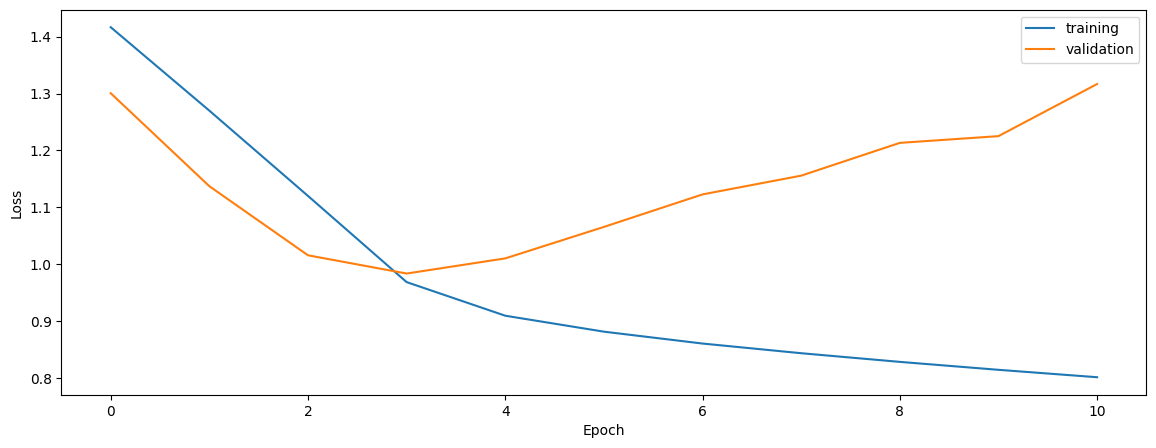

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6490035457354266
0.6276182848693937
0.6073177186714305


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6490035457354266
0.6276182848693937
0.6073177186714305


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6564487906145701
0.6222977868143682
0.6311193501963558


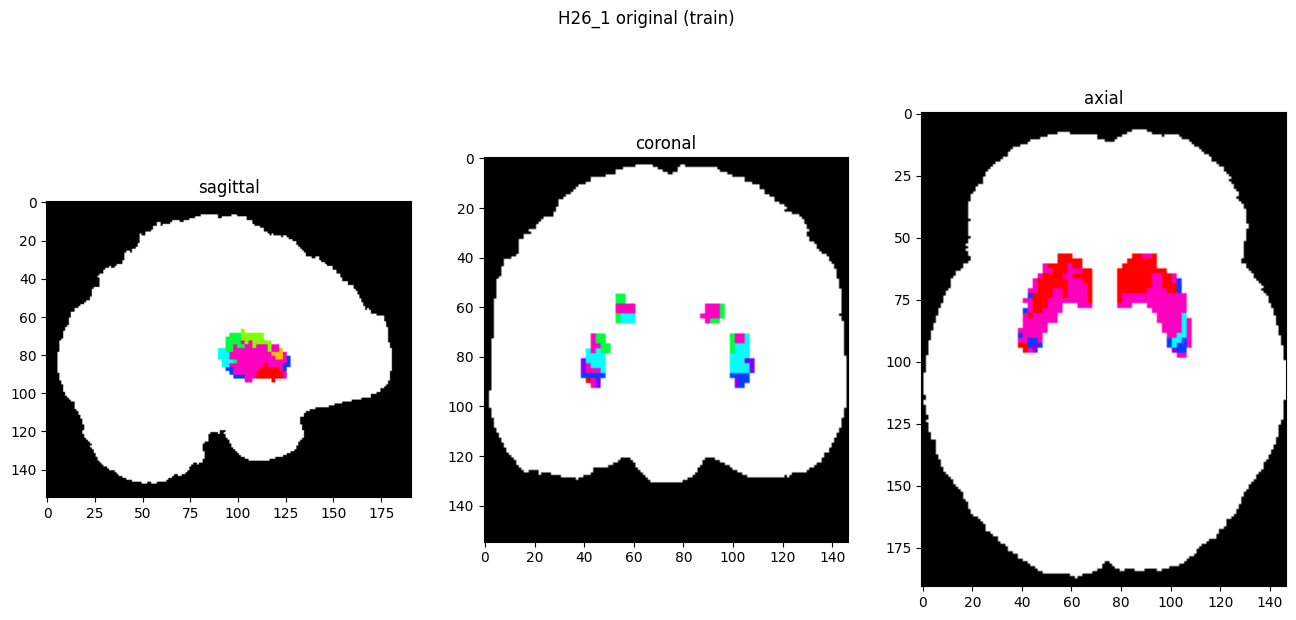

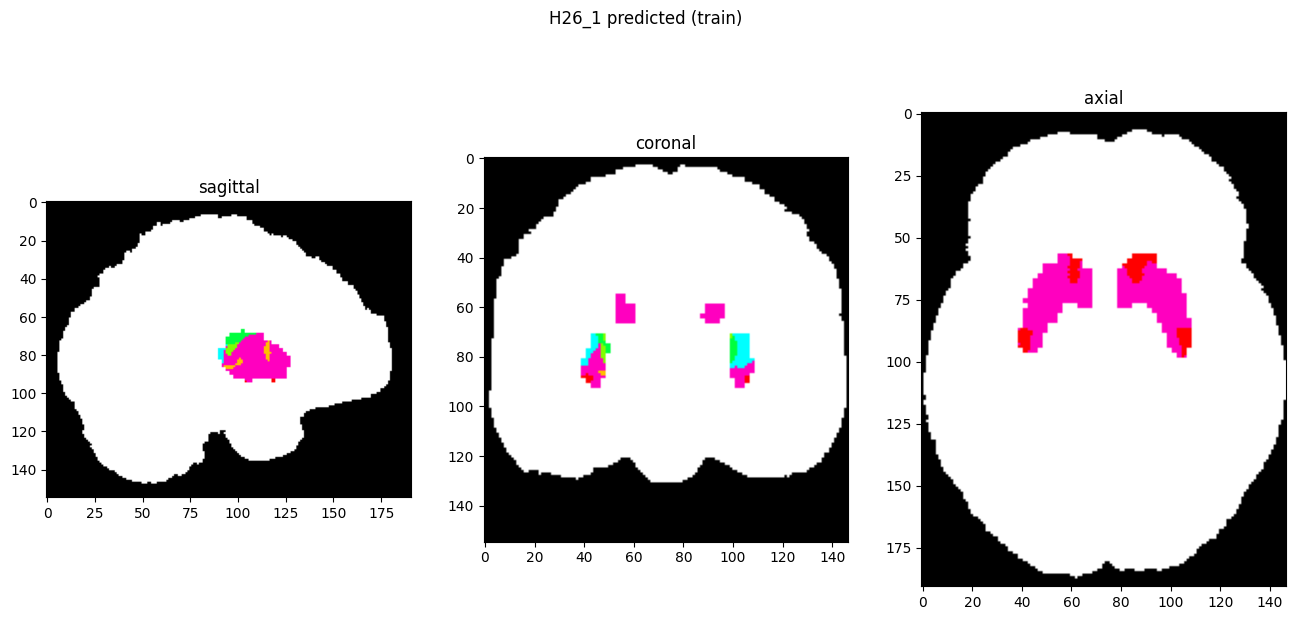

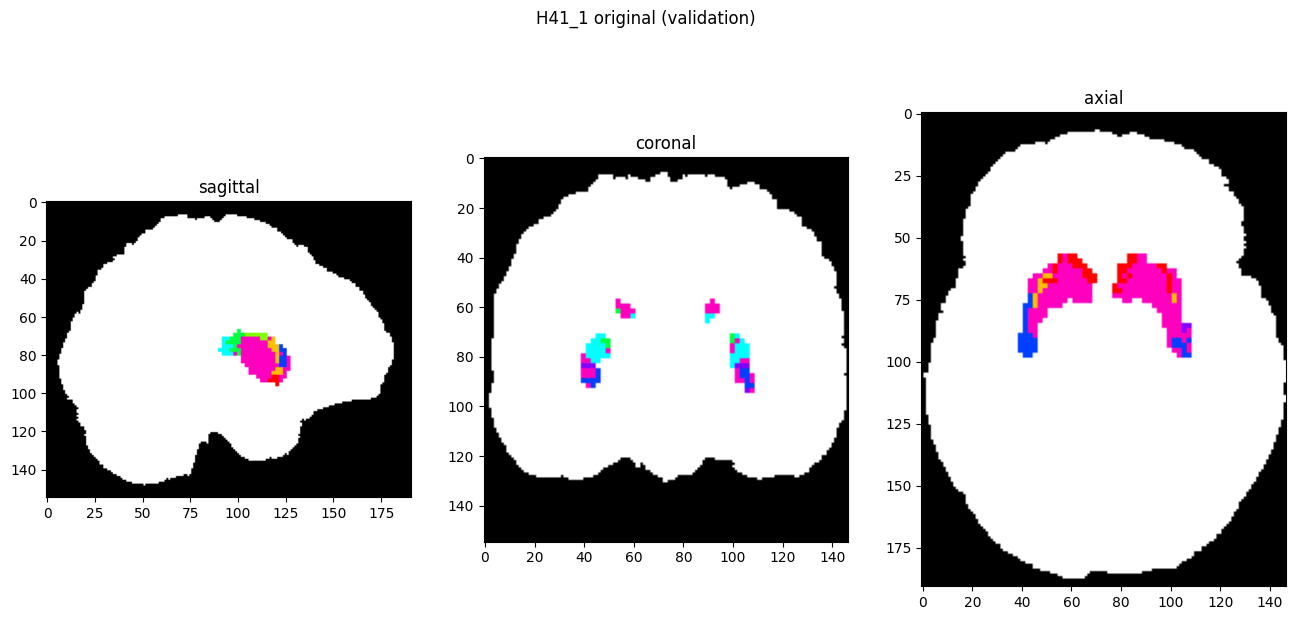

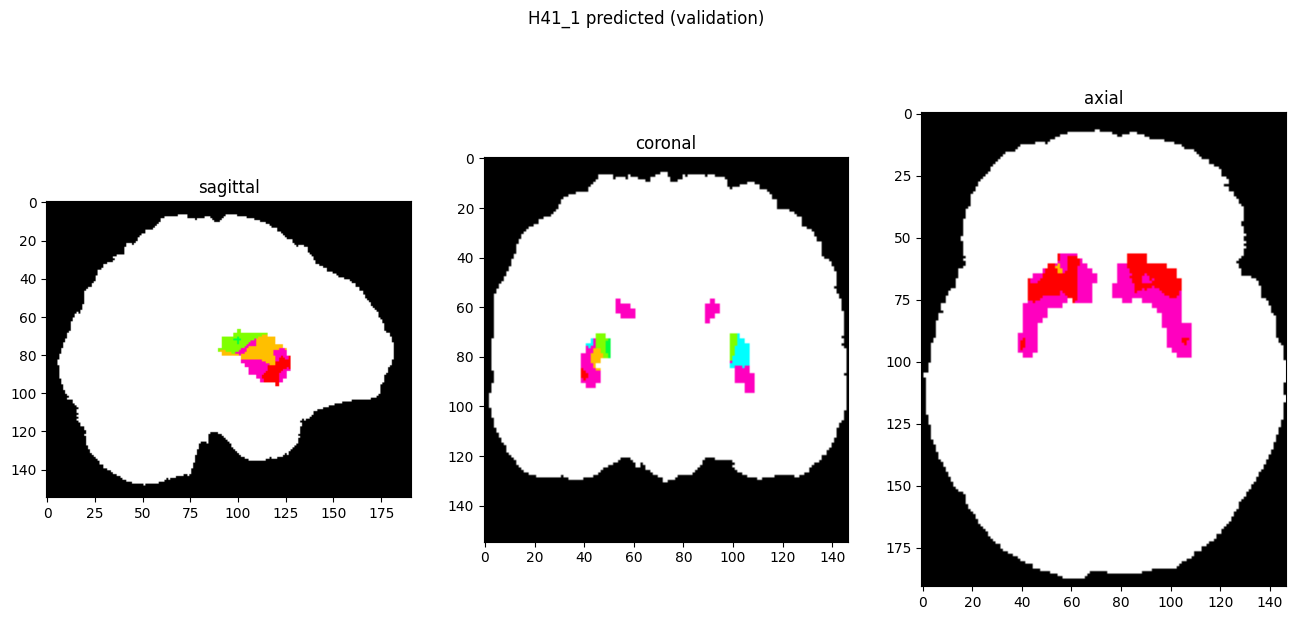

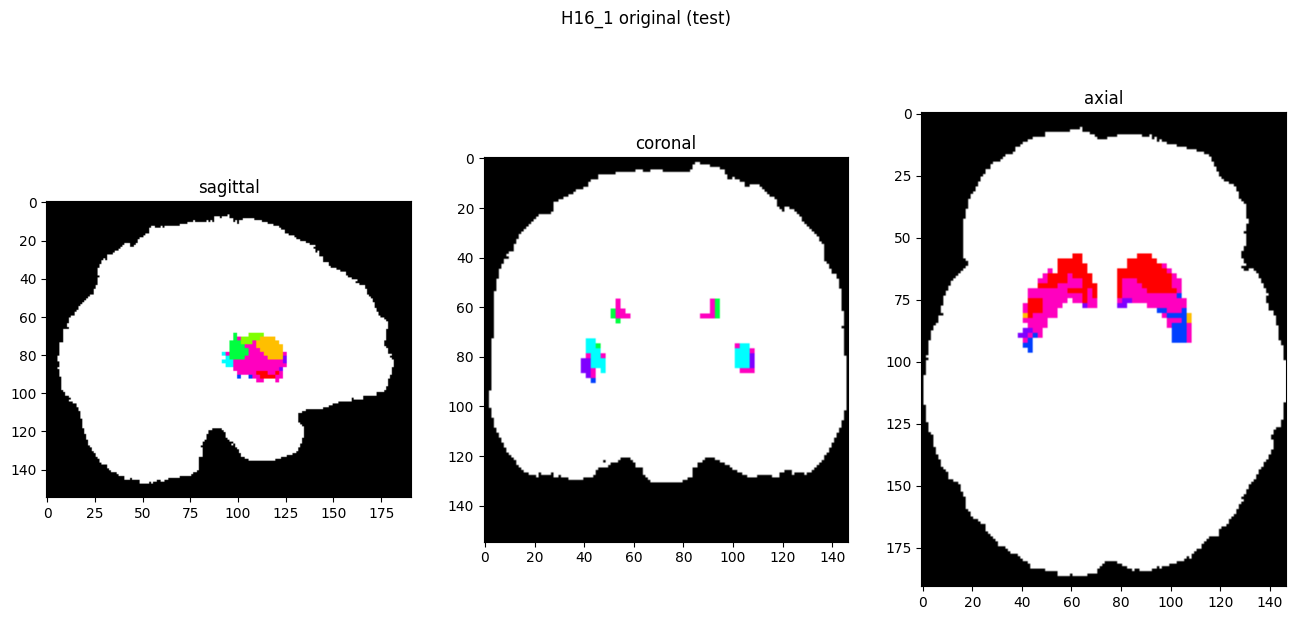

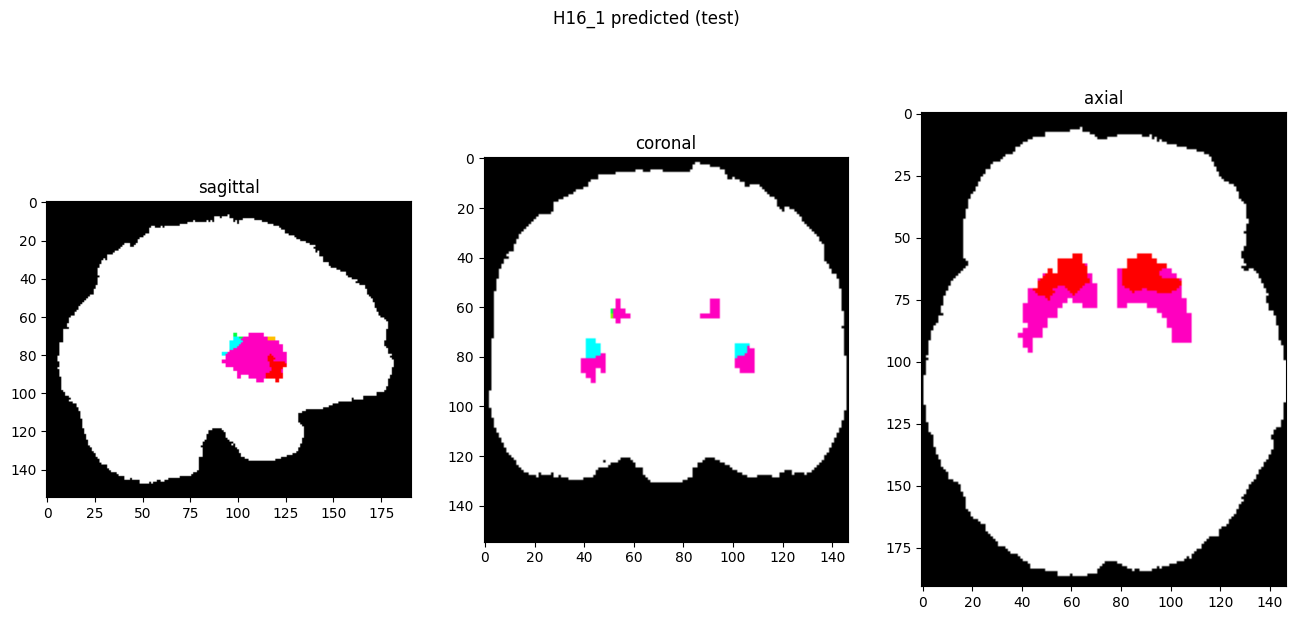

In [10]:
showResults(model, gen, threshold=0)